# DSCI 100 Project Group 1 
**By: Tima Komarov (82239450),**
<br>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("https://raw.githubusercontent.com/crmnwn06/minecraft-data/refs/heads/main/players.csv" )
sessions <- read_csv("https://raw.githubusercontent.com/crmnwn06/minecraft-data/refs/heads/main/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(2025)
clean_player <- players |>
select(played_hours, Age, subscribe)
head(clean_player)

played_hours,Age,subscribe
<dbl>,<dbl>,<lgl>
30.3,9,TRUE
3.8,17,TRUE
0.0,17,FALSE
0.7,21,TRUE
0.1,21,TRUE
0.0,17,TRUE


In [7]:
set.seed(2025)

clean_player <- clean_player |>
mutate(subscribe = as_factor(subscribe)) 
head(clean_player)


played_hours,Age,subscribe
<dbl>,<dbl>,<fct>
30.3,9,TRUE
3.8,17,TRUE
0.0,17,FALSE
0.7,21,TRUE
0.1,21,TRUE
0.0,17,TRUE


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


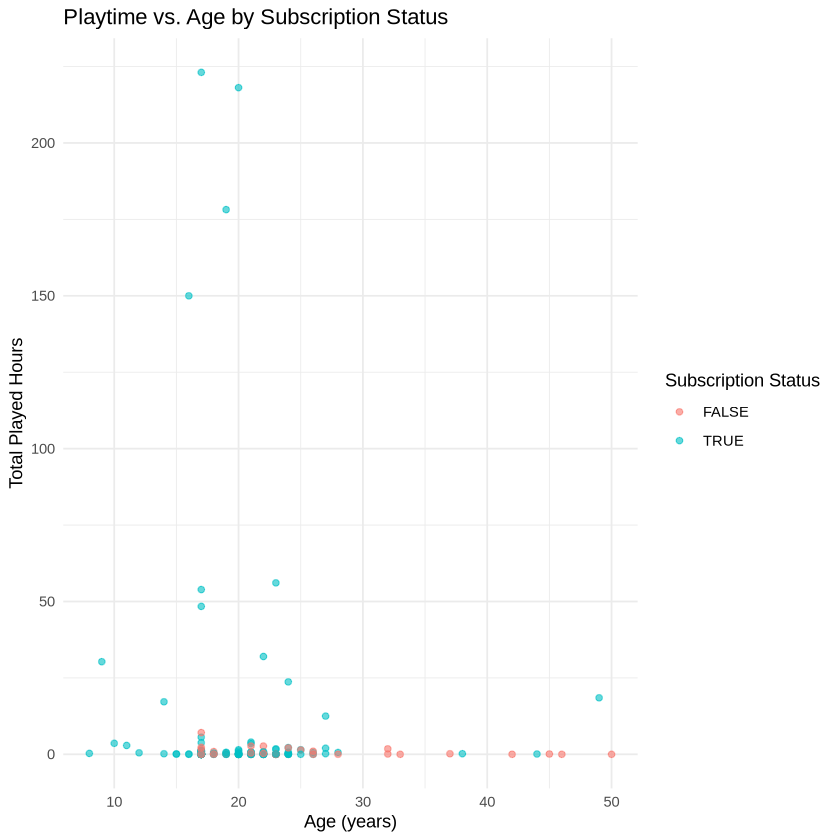

In [10]:
#Visualization of data: Scatter Plot of Playtime vs. Age (Colored by Subscription Status)
ggplot(players, aes(x = Age, y = played_hours, color = as.factor(subscribe))) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Playtime vs. Age by Subscription Status",
    x = "Age (years)",
    y = "Total Played Hours",
    color = "Subscription Status"
  ) +
  theme_minimal()

In [24]:
#Pre modeling work

#splits
player_split <- initial_split(clean_player, prop = 0.8, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

#recipe 
player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

#spec
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#fit
knn_fit <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       fit(data = player_train)
knn_fit

#folds 
#Lmk numbers of folds you guys want to do just kept same as worksheet for now
player_fold <- vfold_cv(player_train, v = 5, strata = subscribe)


Warning message:
“tune samples were requested but there were 156 rows in the data. 151 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2645161
Best kernel: rectangular
Best k: 151

In [25]:
#tuning
k_vals <- tibble(neighbors = seq(from = 1, to = 5, by = 1))

knn_results <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = player_fold, grid = k_vals) |>
       collect_metrics()
knn_results

## I don't know what this error means. I think this is affecting the tuning. 

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6078629,4,0.046600501,Preprocessor1_Model1
1,roc_auc,binary,0.5470260,4,0.045280859,Preprocessor1_Model1
2,accuracy,binary,0.6078629,4,0.046600501,Preprocessor1_Model2
2,roc_auc,binary,0.5551781,4,0.047354858,Preprocessor1_Model2
3,accuracy,binary,0.6159274,4,0.003024194,Preprocessor1_Model3
3,roc_auc,binary,0.5686896,4,0.039857074,Preprocessor1_Model3
4,accuracy,binary,0.5836694,4,0.033388095,Preprocessor1_Model4
4,roc_auc,binary,0.5566123,4,0.043781495,Preprocessor1_Model4
5,accuracy,binary,0.6479335,4,0.013457913,Preprocessor1_Model5


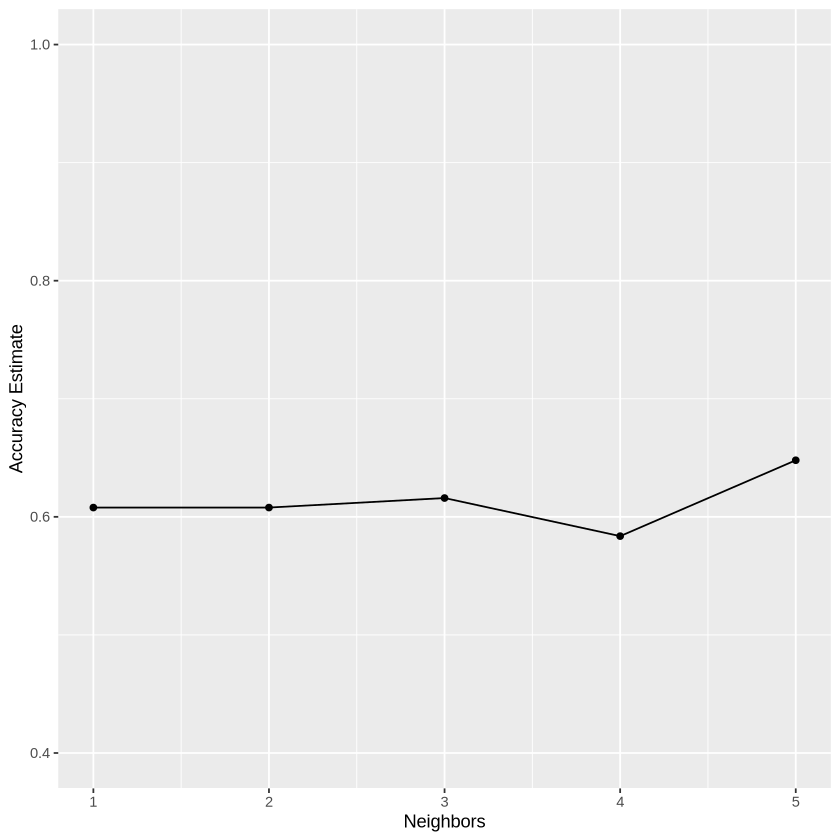

In [26]:
#accuracies 
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

From the graph we can tell that 5 neighbors provides the best accuracy estimation. However, an accuracy of 0.55 does not seem too high. 

In [28]:
#resampling
resample_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

#fit
resample_fit <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(resample_tune) |>
       fit_resamples(resamples = player_fold)
resample_fit

#metrics 
player_metrics <- resample_fit |>
    collect_metrics()
player_metrics

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.

There were issues with some computations   A: x1

There were issues with some computations   A: x1



Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6479335,4,0.01345791,Preprocessor1_Model1
roc_auc,binary,0.5820501,4,0.03820496,Preprocessor1_Model1


**From Conclusion**
Accuracy (0.648 or ~65%)
This means the model correctly classifies ~65% of the instances.

If this is significantly better than random guessing (e.g., for a balanced dataset, random guessing is ~50%), then it's decent.

However, if a simple baseline model (e.g., logistic regression) achieves similar or better accuracy, your KNN model may not be very strong.

2. ROC AUC (0.582 or ~58%)
ROC AUC measures how well the model distinguishes between classes.

A perfect classifier = 1.0, random guessing = 0.5.

Our 0.58 is only slightly better than random guessing, suggesting that the model has weak discrimination power.

3. Standard Error (SE)
Accuracy SE = 0.013, ROC AUC SE = 0.038.

These indicate uncertainty in the performance estimate, but they are relatively small, meaning your results are consistent across resamples.

# Introduction
(Intro Here)

# Methods and Results 
(Results)

# Discussion
(Discussion)

# References